# Predator-prey interaction simulations

This uses a bunch of code from random places as well as my own code, it's mess

In [1]:
import sys
sys.path.insert(0, '../code')
sys.path.insert(0, '../code/Inverse-Reinforcement-Learning-master')
sys.path.insert(0, '../code/sisyphus')

# Nice fonts
import matplotlib.font_manager
import matplotlib
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

import numpy as np
import matplotlib.pyplot as plt
from predators import *
from tqdm import tqdm
import irl.maxent as maxent

np.random.seed(123)

## Create agents

The `Agent` class takes a reward function as its first argument, specified as a string with weights on each environment feature. The policy can be `max`, `softmax` or `pessimism` - pessimism here means that it accounts for negative value so this is useful if we want to assume a predator has a dislike of some features.

The prey's reward function doesn't matter yet as we're not using it.

In [ ]:
predator = Agent('1*Prey_1 + (-0.2*Water) + (0.5*Trees)', name='Predator_1', policy='pessimism', w=0.5)
prey = Agent('0.1*reward + (-1*Predator_1)', name='Prey_1', policy='pessimism', w=0.5)

## Create environment

This adds features, which are randomly generated with multiple clusters of that feature. The name of the featrue corresponds to the features in the agents' reward functions.

In the figure, the blue star represents the prey's location and the red cross represents the predator. Green = trees, blue = water, brown = dirt

(3, 9)


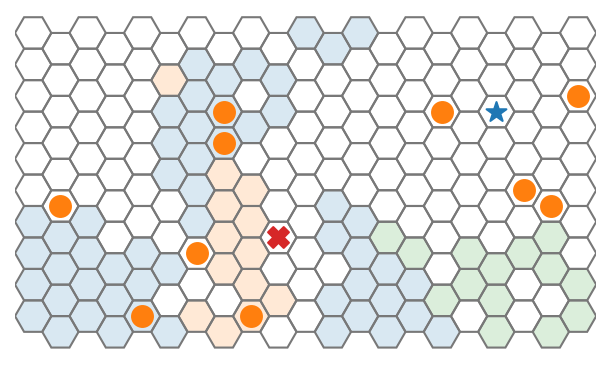

In [3]:
f1 = EnvironmentFeature(n_clusters=3, cluster_size_mean=40, cluster_size_sd=10, name='Water', kind='hex')
f2 = EnvironmentFeature(n_clusters=2, cluster_size_mean=40, cluster_size_sd=10, name='Dirt', kind='hex')
f3 = EnvironmentFeature(n_clusters=2, cluster_size_mean=40, cluster_size_sd=10, name='Trees', kind='hex')

env = PredatorEnvironment(features=[f1, f2, f3], size=(21, 10), n_rewards=10, agents=[predator, prey], overlaps=[[1, 2], [0], [0]],
                          name='Environment_1', kind='hex')
env.plot_environment()

In [4]:
prey.solved = False
predator.solved = False

## Predator state rewards

This shows the reward value of each state in the environment for the predator

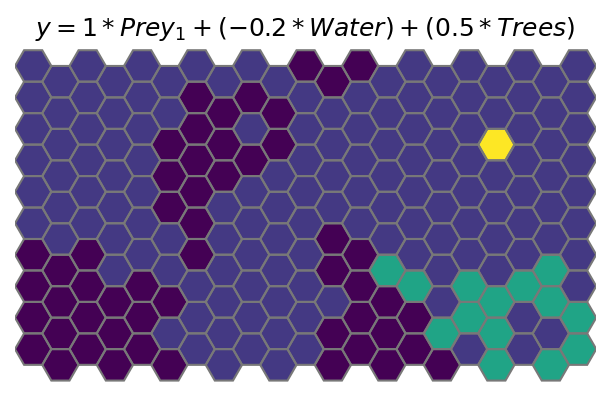

In [5]:
predator.plot_state_rewards()

### Solve the MDP for the predator

Here `gamma` essentially controls how far it looks ahead. 

updated info


../code\sisyphus\mdp\_misc.py:13: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pessimism" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at ../code\sisyphus\mdp\_misc.py (16)

File "..\code\sisyphus\mdp\_misc.py", line 16:
def pessimism(arr, w):
    <source elided>
    """Pessimistic learning rule."""
    return w * np.max(arr) + (1 - w) * np.min(arr)
    ^

  @jit
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\numba\object_mode_passes.py:177: NumbaWarning: Function "pessimism" was compiled in object mode without forceobj=True.

File "..\code\sisyphus\mdp\_misc.py", line 14:
@jit
def pessimism(arr, w):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\numba\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviou

solved
None


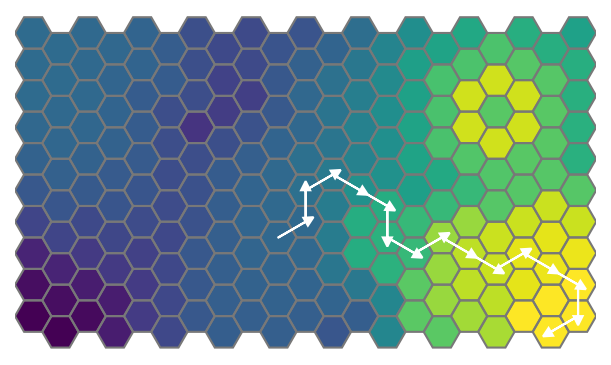

In [6]:
predator.solver.gamma = 0.9
# predator.solver.policy = 'pessimism'
predator.solved = False
predator.plot_policy(head_width=0.05, head_length=0.05)

Here the predator actually avoids the prey and decides to go for the trees instead - smart prey (that understands the predator's reward function) would know that it's relatively safe where it is and so it doesn't need to move.

## Sample predator trajectories

Here we repeatedly place the predator in a random start state and solve the MDP. This generates trajectories that we can pass to the IRL algorithm.

These trajectories are all the same length, and this method currently stops once it reaches a terminal state (this is using a max policy, so if it reaches a state where there are no better adjacent states it'll just stay there) so we need to make sure we select trajectories with the right length (currently set to 6 moves). We'll need to figure out how to use trajectories of different lengths at some point.

`gamma` represents the discount function, if higher the agent effectively looks further into the future

In [67]:
trajectories = np.zeros((10, 10, 2))

count = 0

while count < trajectories.shape[0]:
    idx = (np.random.randint(10), np.random.randint(10, 20))
    predator.idx = idx
    predator.solver.gamma = 0.9
    predator.solver.policy = 'max'
    predator.solved = False
    predator.solve()
    if len(predator.solver.pi) < trajectories.shape[1] + 1:
        # Repeat the final state if a terminal state is reached early
        trajectories[count, ...] = np.vstack([predator.solver.sa_pairs[:10, :], predator.solver.sa_pairs[None, -1, :].repeat(trajectories.shape[1] - predator.solver.sa_pairs.shape[0], axis=0)])
        count += 1
        
trajectories = trajectories.astype(int)

updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved
updated info
solved


## IRL

Now we can take the trajectories and run the MaxEnt algorithm to try recovering the predator's reward function.

First we get the features of the environment in a format that the MaxEnt code will take, and then try running it! We set the gamma to the same value used for generating trajectories and the maximum number of actions to 6, as used to generate trajectories.

In [68]:
feature_matrix = env.feature_matrix()
discount = 0.9
n_actions = 6
feature_keys = [i for i in env.feature_arrays]

This runs the algorithm, the number of iterations is the second to last argument, the last argument is the learning rate. The recovered reward function is given as  `a`

In [69]:
r, a, g = maxent.irl(feature_matrix, n_actions, discount, predator.sas, trajectories[:10, :6, :], 20, 0.2)

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19


In [70]:
predator.function

'1*Prey_1 + (-0.2*Water) + (0.5*Trees)'

We can plot the recovered reward function to see how well it did

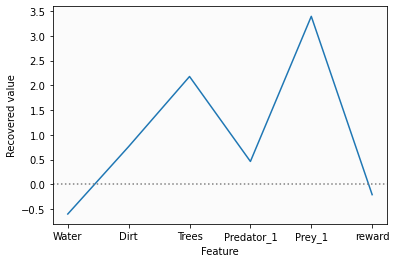

In [77]:
plt.plot(a)
plt.axhline(0, linestyle=':', color='gray')
plt.ylabel('Recovered value')
plt.xlabel('Feature')
plt.xticks(range(len(feature_keys)), feature_keys);

This isn't perfect but it doesn't do a terrible job - it figures out that the predator cares about trees and prey, and the weight on water is correctly negative. However it does get some things wrong, and the absolute values aren't right